# Road Damage Model Identifier Training and Implementation

### An Image Segmentation Project Using FastAi

### Import Packages

In [ ]:
# Import packages
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

from fastai.vision.all import *
from fastai.basics import *
from fastai.callback.all import *

# fastai library doesn't just return a string containing the path to the dataset, but a Path object. 
# is a useful class from the Python 3 standard library that makes accessing files and directories much easier.
from pathlib import Path

In [ ]:
path= Path()

In [ ]:
# import the image and mask file paths 
fnames = get_image_files(path/"images")
lbl_names = get_image_files(path/'mask')

In [ ]:
lbl_names

(#100) [Path('mask/Czech_000061.png'),Path('mask/Czech_000100.png'),Path('mask/Czech_000193.png'),Path('mask/Czech_000017.png'),Path('mask/Czech_000002.png'),Path('mask/Czech_000271.png'),Path('mask/Czech_000245.png'),Path('mask/Czech_000159.png'),Path('mask/Czech_000183.png'),Path('mask/Czech_000092.png')...]

In [ ]:
np.array(PILMask.create(fnames[0]))

array([[ 77,  90, 107, ..., 194, 193, 193],
       [ 85,  95, 107, ..., 196, 195, 195],
       [ 89,  96, 103, ..., 196, 196, 195],
       ...,
       [ 27,  29,  28, ...,   1,   1,   1],
       [ 29,  32,  30, ...,   1,   1,   1],
       [ 13,  16,  14, ...,   1,   1,   1]], dtype=uint8)

In [ ]:
# goes through the mask files and stores a dictionary with each of the values. In our images we have black and white so
# will store two values
def n_codes(fnames, is_partial=True):
    "Gather the codes from a list of `fnames`"
    vals = set()
    if is_partial:
        random.shuffle(fnames) # take a random sample of the mask files
        fnames = fnames[:10] # select 10
    for fname in fnames:
        msk = np.array(PILMask.create(fname)) # creates an array with each of the levels in the png file
        for val in np.unique(msk): # find unique values in array (in this case just two values 0 (white) & 255 (black))
            if val not in vals:
                vals.add(val)
    vals = list(vals)
    p2c = dict()
    for i,val in enumerate(vals):
        p2c[i] = vals[i] #unique values are mapped sequentially to numbers starting at 0 -> {0:0, 1: 255}
    return p2c

#

In [ ]:
vals = n_codes(lbl_names)

#### Explanation Break: n_codes function breakdown

In [ ]:
# creates an array with each of the levels in the png file
# e.g. running on the main images can see many layers 
np.array(PILMask.create(fnames[0]))

array([[ 77,  90, 107, ..., 194, 193, 193],
       [ 85,  95, 107, ..., 196, 195, 195],
       [ 89,  96, 103, ..., 196, 196, 195],
       ...,
       [ 27,  29,  28, ...,   1,   1,   1],
       [ 29,  32,  30, ...,   1,   1,   1],
       [ 13,  16,  14, ...,   1,   1,   1]], dtype=uint8)

In [ ]:
# but if run on mask see only 2 layers 
np.array(PILMask.create(lbl_names[0]))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Main Code Continued:

Replace the coding format in the mask files with the new format just creates i.e. {0:0, 1: 255}

In [ ]:
path/'mask'/f'{fnames[0]}.png'

Path('mask/images/Czech_000217.jpg.png')

In [ ]:
def get_my_y(fname:Path): 
    fn = path/'mask'/f'{fname.stem}.png'
    msk = np.array(PILMask.create(fn))
    mx = np.max(msk)
    for i, val in enumerate(vals):
        msk[msk==vals[i]] = val
    return PILMask.create(msk)


#### Explanation Break: get_my_y function breakdown

In [ ]:
path/'mask'/f'{fnames[0]}' # get the path to the image

Path('mask/images/Czech_000217.jpg')

In [ ]:
path/'mask'/f'{fnames[0].stem}.png' #stem removes the .jpg and we replace it with png

Path('mask/Czech_000217.png')

In [ ]:
temp_png = path/'mask'/f'{fnames[0].stem}.png'

In [ ]:
temp_png_mask = np.array(PILMask.create(temp_png)) # temporarily create a new mask file for the mask
temp_png_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
np.unique(temp_png_mask) # but currently still have old encoding

array([  0, 255], dtype=uint8)

In [ ]:
np.max(temp_png_mask) # find the max value to iterate up to 

255

In [ ]:
temp_png_mask[temp_png_mask==255] = 1 # map the items based on our new encoding iteratively

In [ ]:
np.unique(temp_png_mask)

array([0, 1], dtype=uint8)

#### Main Code Continued

In [ ]:
# labels used in datablock
codes = ['good', 'damage']

In [ ]:
# Data Block is essentially the equivalent to the pipeline in Scikit Learn.
# A DataBlock is just a blue print on how to assemble your data. It does not do anything until you pass it a source. 
# You can choose to then convert that source into a Datasets or a DataLoaders by using the DataBlock.datasets or 
# DataBlock.dataloaders method.

# To build a DataBlock you need to give the library four things: 
# the types of your input/labels, and at least two functions: get_items and splitter.


ds = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files, # where is the data
                   splitter=RandomSplitter(), # how to split data. Usually a random split between the training and validation dataset.
                   get_y=get_my_y, # what to apply to the outputs
                   item_tfms=Resize(224), # item transform applied on an individual item basis. This is done on the CPU.
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]) # is batch transform applied on batches of data. This is done in GPU.

# note on batch transformation
# .normalize normalises the data. Neural nets want  data to have a mean of zero and a standard deviation of 1. 
# done by subracting from each score the mean of the variable and then deviding it by the standard deviation of 
# that variable. 
# The mean and sd of the imagenet data are stored in the imagenet_stat variable.
# (Note that if you use the imagenet pretrained model. You do not want to use the mean and standard 
# deviations of your data but the mean and standard deviation of the original imagenet data.)

#### Explanation Break: datablocks and dataloaders recap

**A DataBlock** is equivalent to the pipeline in Scikit Learn. Its contains instructions to follow when building batches and DataLoaders. As its only a blueprint it doesn’t explicitly need any data.

**DataLoaders or DataSet** are essentially the data set. PyTorch and fastai use two main classes to represent and access a training or validation set. These are created by converting a DataBlock using an inbuilt method. 
- **DataBlockVar.Dataset:** An object that contains a training Dataset and a validation Dataset. I.e. a collection that returns a tuple of your independent and dependent variable for a single item.
- **DataBlockVar.DataLoader**: An object that contains a training DataLoader and a validation DataLoader. I.e. an iterator that provides a stream of mini-batches, where each mini-batch is a couple of batches of independent variables and a batch of dependent variables

**The steps are defined by the data block API:**
- What is the types of your inputs/targets? (Blocks)
- Where is your data? (get_items)
- Does something need to be applied to inputs? (get_x)
- Does something need to be applied to the target? (get_y)
- How to split the data? (splitter)
- Do we need to apply something on formed items? (item_tfms)
- Do we need to apply something on formed batches? (batch_tfms)


Notes summarised from: https://www.educative.io/edpresso/what-is-data-block-api-in-fastai


In [ ]:
# create the dataloader from the datablock
dls = ds.dataloaders(path/'images', bs=4)
# bs (int): how many samples per batch to load

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


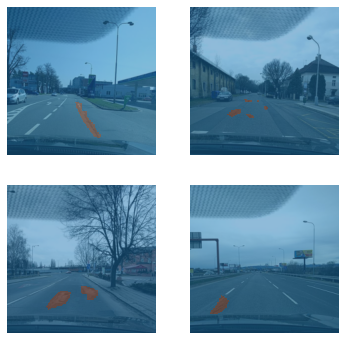

In [ ]:
# View a sample of a batch looks like.
# Note there are 4 images included in each batch
dls.show_batch()

In [ ]:
# A traditional CNN won't work for segmentation, therfore use a special kind of model called a UNet, 
# Convolutional neural network; a type of neural network that works particularly well for computer vision tasks
# Creating the model setup (not actually fitting it here)
learn = unet_learner(dls, resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#### Explanation Break: Why are we using a unet_learner?

Computer vision applications use the functions `cnn_learner` and `unet_learner` to build models, depending on the task. unet_learner works in similar way to cnn_learner but specifically for

**cnn_learner:** what happens when we use the cnn_learner function? Begin by passing this function an architecture to use for the body of the network. Most of the time use a ResNet. Pretrained defaults to True,weights are downloaded as required and loaded into the ResNet  which sets the weights of the model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the famous ImageNet dataset). Parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks. For transfer learning, the network needs to be cut i.e. slicing off the final layer, which is only responsible for ImageNet-specific categorization. I.e. When using a pretrained model, cnn_learner will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the head.

**unet_learner:** modifed form of a cnn_learner. start with a ResNet, for instance, and cut off the adaptive pooling layer and everything after that. Then replace those layers with our custom head, which does the generative task.

https://nvkgqt3seu.clg07azjl.paperspacegradient.com/notebooks/15_arch_details.ipynb

**Resnet50:** Residual Network. It is a 50 layer Residual Network. There are some standard architectures that work most of the time. Resnet is both fast and accurate for many datasets and problems. The 34 in resnet34 refers to the number of layers in this variant of the architecture (other options are 18, 50, 101, and 152). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

In [ ]:
# learn.save('model')

Path('models/model.pth')

In [ ]:
# fit the model (fine_tune = A transfer learning technique where the parameters of a pretrained model are updated 
# by training for additional epochs using a different task to that used for pretraining.)

# Model already run therefore just import below
#learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,0.254306,0.059519,01:08


epoch,train_loss,valid_loss,time
0,0.043766,0.047991,00:24
1,0.041232,0.045773,00:24
2,0.039124,0.054043,00:24
3,0.037176,0.043224,00:24
4,0.034812,0.040053,00:24
5,0.033302,0.058728,00:24
6,0.030804,0.040365,00:24
7,0.027948,0.046618,00:24
8,0.025257,0.056412,00:24
9,0.023213,0.050137,00:24


#### Explanation Break: fine_tune
fine_tune essentially = .fit in Scikit learn. 
Called "fine_tune" instead of fit as we are using a pretrained model. 

Have to provide at least one piece of information: how many times to look at each image (known as number of epochs). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

Epoch = One complete pass through the input data

In [ ]:
# model already trained therefore don't rerun but load below
# learn.save('model_tune')

In [ ]:
# load the model that was saved above
# note that its required that the learn object i.e. the model is created before doing this (this was done above)
learn = learn.load('model_tune')

In [ ]:
# # exporting as pkl reduces the file size somewhat c.1.3gb but still too big
# learn.export()
# path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# # even just saving the weights only reduces file size to 1.3gb 
# import torch
# torch.save(learn.state_dict(), 'model_tune')

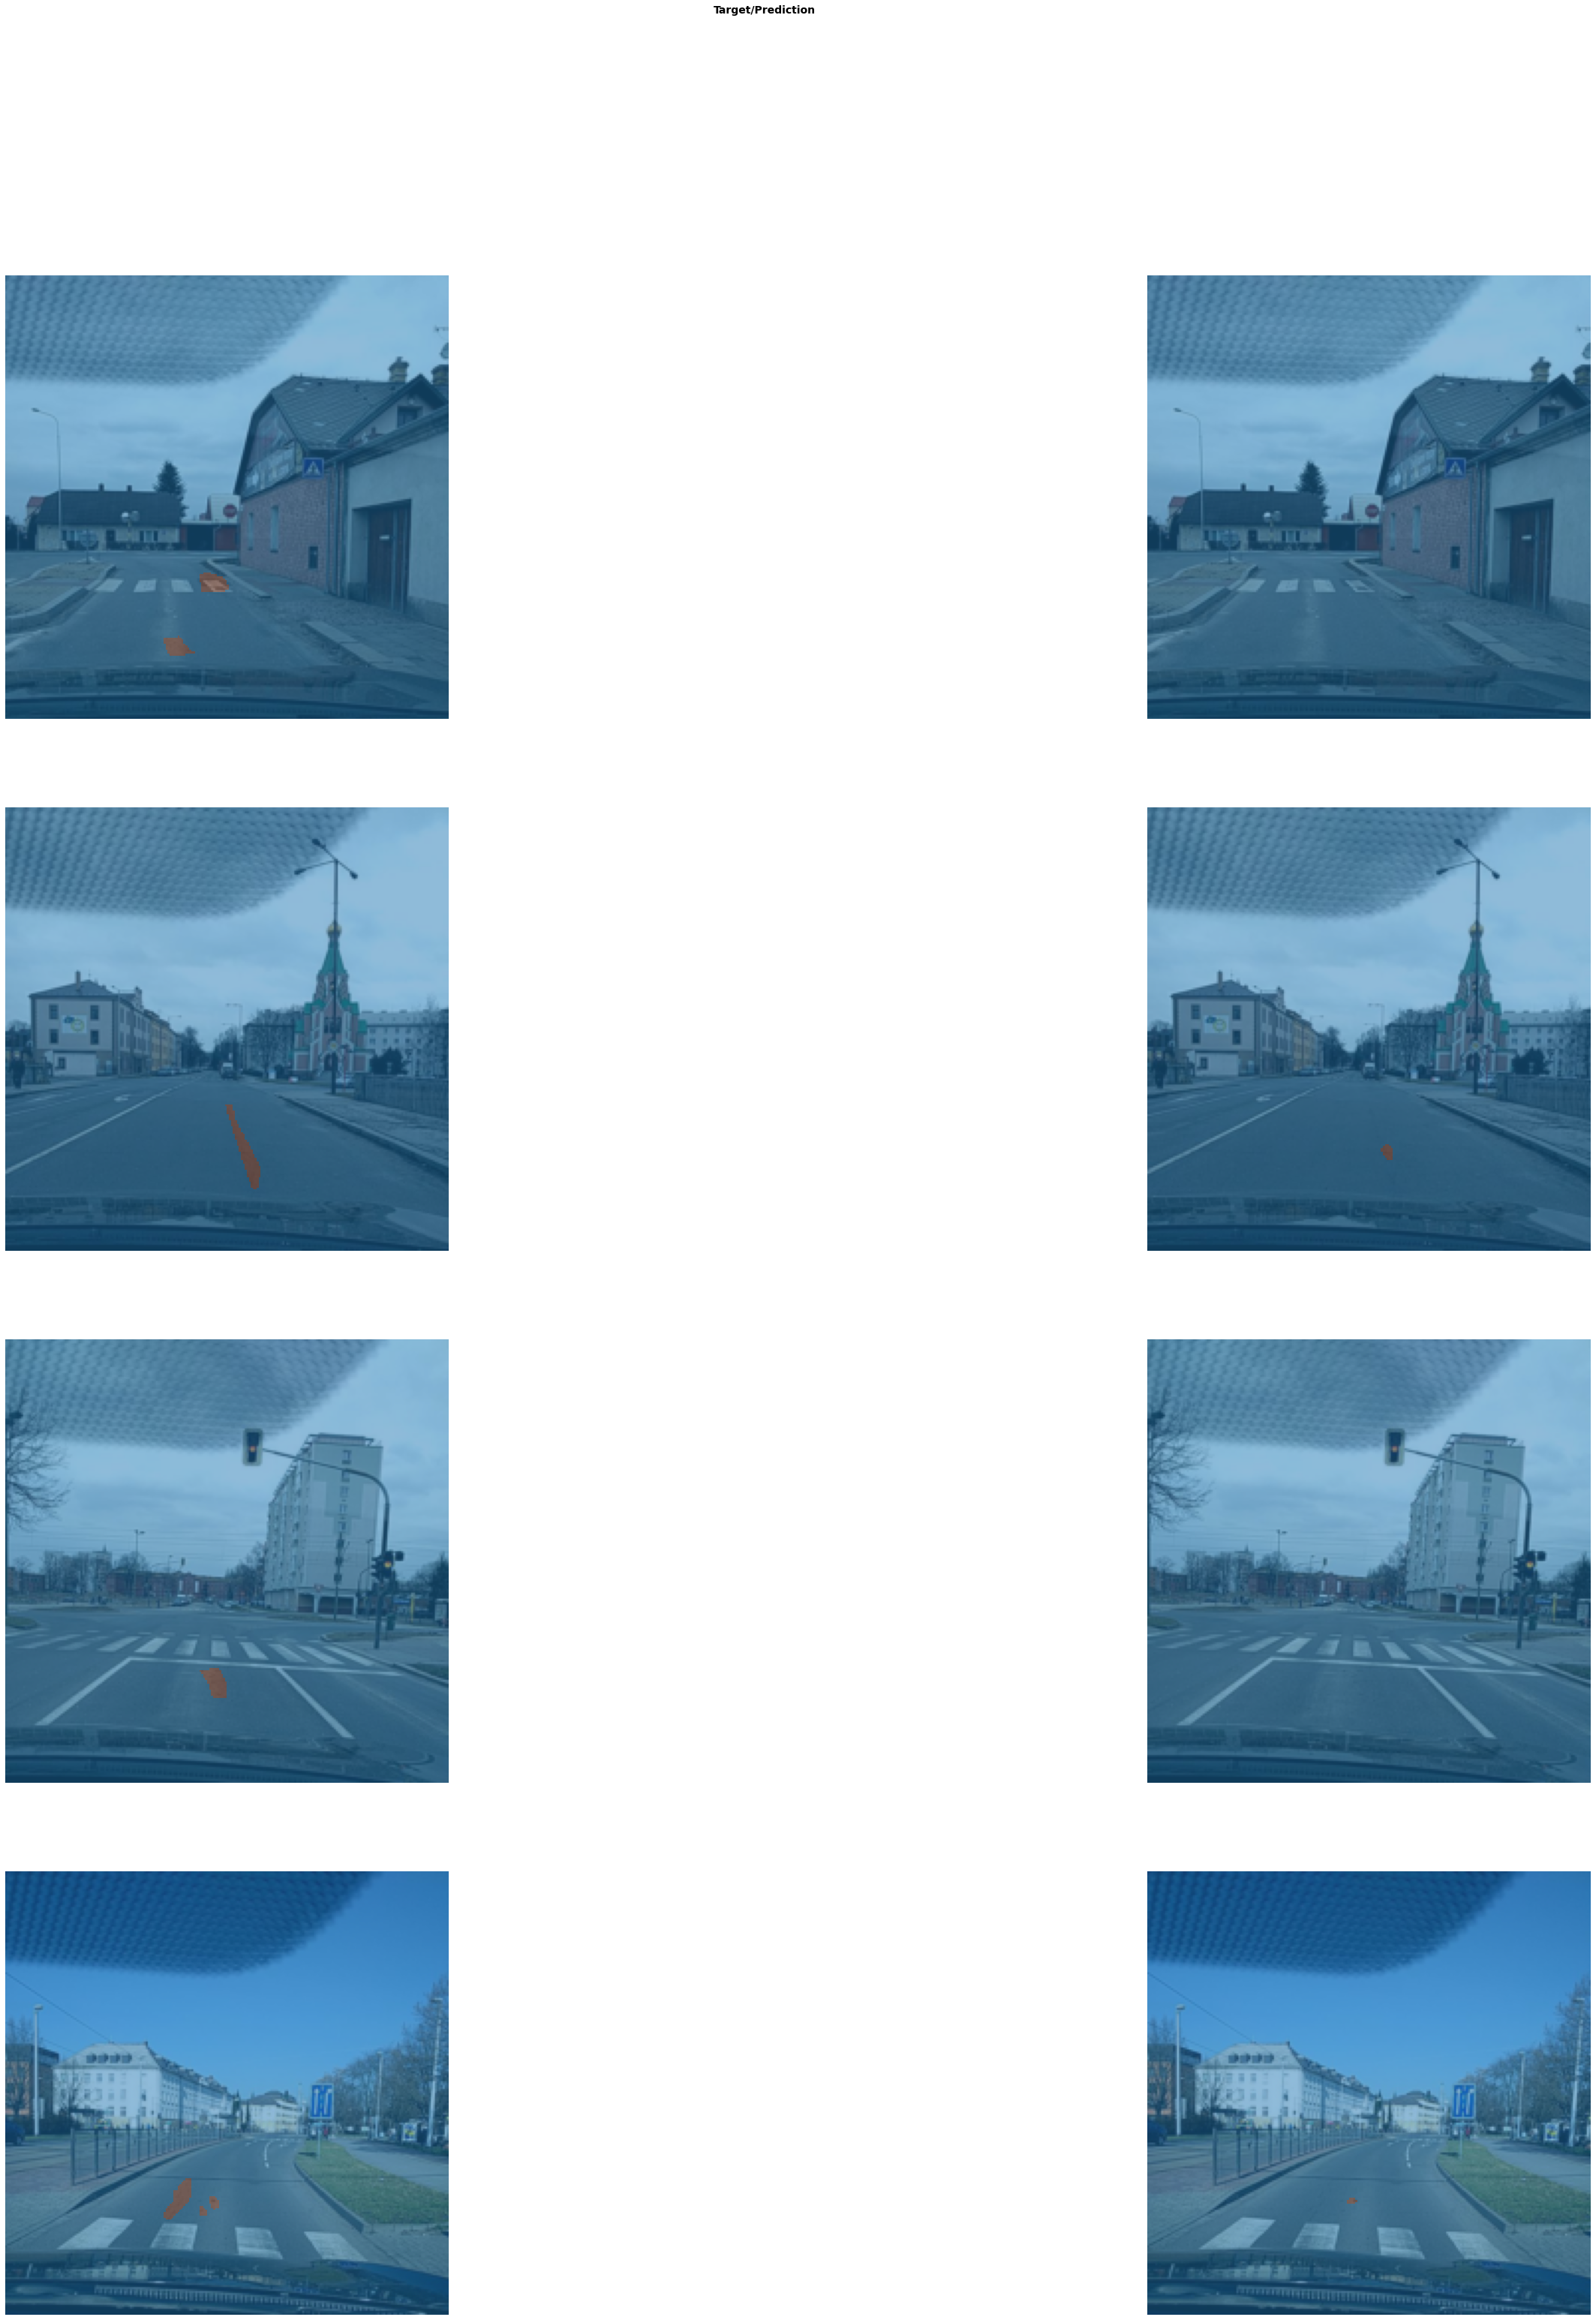

In [ ]:
# Look at some of the results
learn.show_results(max_n=8, figsize=(50,50))

In [ ]:
# OpenCV-Python is a library of Python bindings designed to solve computer vision problems.
# had to run the following installations in addition to enable opencv-python to run on paperspace
# need to run in terminal as can't answer y/n in jupyter

# apt-get update
# apt-get upgrade
# apt install libgl1-mesa-glx
# pip install opencv-python 
import cv2 #import opencv-python (uses the old name still for import)
cv2.__version__

'4.5.4-dev'

In [ ]:
pred = learn.predict('test_images/Czech_000302.jpg')

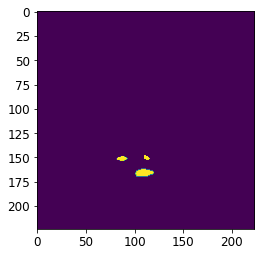

In [ ]:
plt.imshow(pred[0],) #plt.imshow: Display data as an image

In [ ]:
plt.imsave('Czech_000302_solution.png', pred[0]) #Save an array as an image file.

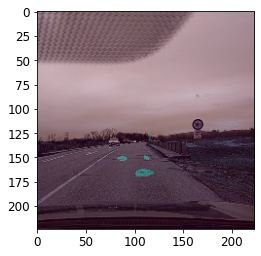

In [ ]:
img1 = cv2.imread('test_images/Czech_000302.jpg') # cv2.imread() method loads an image from the specified file. 
img2 = cv2.imread('Czech_000302_solution.png')

img1=cv2.resize(img1, (224,224))
img2=cv2.resize(img2, (224,224))

result = cv2.addWeighted(img1, 0.7, img2, 0.3, 0)
plt.imshow(result)

# addWeighted is a function that helps in alpha blending of the image. Alpha blending helps in overlaying a 
# foreground image with a transparent look while it has a background image over this one. The transparency is usually 
# the fourth channel of any image. This transparency mask is known as an alpha mask. The foreground image is on the 
# top left, while the gray scale is the alpha mask which is on the top right.

#### Fundamentals for Binder Application

In [ ]:
img_uploaded = widgets.FileUpload()
img_uploaded

FileUpload(value={}, description='Upload')

In [ ]:
pred = learn.predict(img_uploaded.data[-1])

In [ ]:
plt.imsave('solution.png', pred[0]) #Save an array as an image file.

In [ ]:
img1 = np.array(PILImage.create(img_uploaded.data[-1]))
img2 = cv2.imread('solution.png')



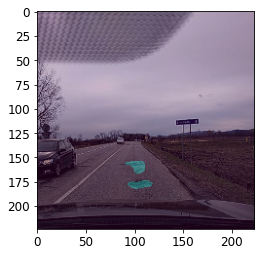

In [ ]:
img1=cv2.resize(img1, (224,224))
img2=cv2.resize(img2, (224,224))

result = cv2.addWeighted(img1, 0.7, img2, 0.3, 0)
plt.imshow(result)
plt.imsave('final.png',result)

#### References: 
- FastAi course: https://walkwithfastai.com/Segmentation#Inference
- Educative: https://www.educative.io/edpresso/what-is-data-block-api-in-fastai
- Mani Rajan: https://www.youtube.com/watch?v=ILz8mkgfSx0